# Quantum Teleportation



This notebook has been made to give a comprehensive understanding of the **quantum teleportation protocol** (aka Alice and Bob protocol). We will use the python SDK [Qiskit](https://www.ibm.com/quantum/qiskit) developped by [IBM](https://www.ibm.com).

## Rough introduction

The **quantum teleportation protocol** demonstrates the power of **entangled states** in quantum computation. This protocol aims to tranmit a quantum state between two parties with a small classical overhead

# Requirements


## Technical requirements

As mentionned above, some python packages need to be installed: `qiskit`, `qiskit_ibm_runtime`,  `qiskit_aer` and `matplotlib`

In [61]:
!pip install qiskit qiskit_ibm_runtime qiskit_aer matplotlib

## Theoretical requirements

To understand this notebook, we provide both a theoretical and pratical approach. However, some basic notions are required such as *the ket*, *qubit* or *the tensor product*. Some good references are available on internet.

- [IBM quantum learning platform](https://quantum.cloud.ibm.com/learning/en)
- [The bible for quantum computation](https://archive.org/details/QuantumComputationAndQuantumInformation10thAnniversaryEdition/page/n305/mode/2up)
- [Mathematics behind quantum computation](https://link.springer.com/book/10.1007/978-3-030-12358-1) (quite indigestible to assimilate)

## Entanglement state

An entanglement state is a quantum state that represents at any time two quantum systems indistinguishable from each other. For example, let's say that a quantum system is described as a particle. The particles of our two systems are staying billions of kilometers away from each other. If those two particles are entangled, when one of these has been read out, we can **instantly** determine the state of the other no matter the distance. Since the speed light is finite, it is quite fancy to admit the transmission of information from one galaxy to another is done in a snap!



More formally, assume two quantum systems $H_A$, $H_B$ and a entangled state $\ket{\psi}$. We have for any state $\ket{\psi}_A \in H_A$ and $\ket{\psi}_B \in H_B$,
$$
\ket{\psi} \neq \ket{\psi}_A \otimes \ket{\psi}_B
$$
For example, the Bell state $\ket{\Psi} = \frac{1}{\sqrt{2}} (\ket{00} + \ket{11})$ is said to be entangled since it is **impossible to find two distinct states** such that the tensor product between them results in $\ket{\Psi}$.

> **PROOF**:
> 
> Let's suppose there exists two distincs states  $\ket{\psi}_A \in H_A$ and $\ket{\psi}_B \in H_B$ such that
> $$
\frac{1}{\sqrt{2}} (\ket{00} + \ket{11}) = \ket{\psi}_A \otimes \ket{\psi}_B
> $$
> Therefore, we have
> $$
\frac{1}{\sqrt{2}} (\ket{00} + \ket{11}) = (\alpha_A \ket{0} + \beta_A \ket{1}) \otimes (\alpha_B \ket{0} + \beta_B \ket{1})\\
\frac{1}{\sqrt{2}} (\ket{00} + \ket{11}) = \alpha_A\alpha_B \ket{00} + \beta_A\alpha_B \ket{10} + \alpha_A\beta_B \ket{01} + \beta_A\beta_B \ket{11}
> $$
> which is equivalent to the following equations:
>
> - $\alpha_A\alpha_B  = \frac{1}{\sqrt{2}}$ 
> - $\beta_A\alpha_B = 0$
> - $\alpha_A\beta_B = 0 $
> - $\beta_A\beta_B = \frac{1}{\sqrt{2}}$
> 
> We see easily the unfeasibility of the system.


To create $\ket{\Psi}$, we apply a Hadamard gate ($H$) on the first qubit (starting from the top) and a $CNOT$ gate on both qubits.

> *Proof*:
> $$
> \frac{1}{\sqrt{2}} (\ket{00} + \ket{11}) = CNOT((H \otimes I) \ket{00})\\
> $$
> where $CNOT= \begin{bmatrix}1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ 0 & 0 & 0 & 1\\ 0 & 0 & 1 & 0 \end{bmatrix}$ and $H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1\end{bmatrix}$
> $$
> \frac{1}{\sqrt{2}} (\ket{00} + \ket{11}) = CNOT(\ket{+} \otimes \ket{0})\\
> $$
> where $\ket{+} = \frac{\ket{0} + \ket{1}}{\sqrt{2}}$
> $$
> \frac{1}{\sqrt{2}} (\ket{00} + \ket{11}) = CNOT\left(\frac{1}{\sqrt{2}} (\ket{0} + \ket{1}) \otimes \ket{0}\right)\\
> \frac{1}{\sqrt{2}} (\ket{00} + \ket{11}) = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0\\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{bmatrix}\begin{bmatrix}1 \\0 \\ 1\\0 \end{bmatrix}\\
> \frac{1}{\sqrt{2}} (\ket{00} + \ket{11}) = \frac{1}{\sqrt{2}}\begin{bmatrix}1 \\0 \\ 0\\1 \end{bmatrix}

> $$

Let's code the circuit!

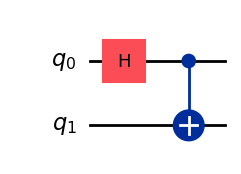

In [ ]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(2)

circuit.h(0) # Hadamard gate 
circuit.cx(0, 1) # CNOT gate

circuit.draw(output="mpl")

Now, let's run a simulator to see which observables might be seen the most

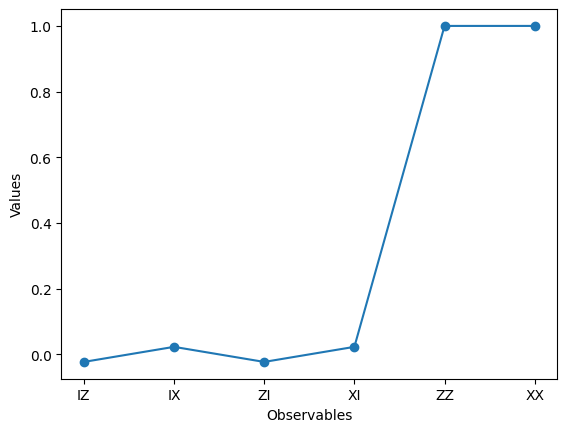

In [63]:

from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

from matplotlib import pyplot as plt

backend = FakeAlmadenV2()
estimator = Estimator(backend)

observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]


 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
  
job_result = job.result()
 
pub_result = job.result()[0]

values = pub_result.data.evs
 
errors = pub_result.data.stds
 
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

## Quantum teleportation protocol

The protocol goes as follows. We have two parties involved: Alice and Bob. Alice wants to send a qubit to Bob without giving it explicitly. To do so, Alice and Bob shares a Bell state $\ket{\Psi}$ while Alice has the qubit $\ket{\phi} = \alpha \ket{0} + \beta \ket{1}$ she wants to transmit. These are the initial conditions for the protocol. For the entire process, we can follow the quantum circuit below:

![image.png](image.png)

(the dotted lines outline the spatial distance between Alice and Bob)

We can see that Bob perfoms calculations on his bell state based on the outcome of the measurement from $\ket{\phi}$ and her bell state. Let denote the measurement of the qubit $\ket{\Psi}$ for the observable $O$ as $M(\Psi;O) \in \{0,1\}$. We finally define properly all the steps of the protocol:
- first step: applying $CNOT$ gate where the target qubit is $\ket{\phi}$ and the control qubit is $\ket{\Psi}$ 
- second step: hadamard gate on Alice's qubit $\ket{\Psi}$
- third step: measurement $a=M(\phi;Z)$ and $b = M(\Psi_2;Z)$ where $\ket{\Psi}_2$ is the Alice's bell state after application of $CNOT$ and $H$ in the circuit
- fourth and last step: application of $Z^aX^b$ on the bell state of Bob

>**PROOF OF CORRECTNESS**:
>
> we will use $\ket{\psi_i}$ to denote the state of the system at the i-th step.
>
>**First step**:
>$$
\ket{\psi_1} = \ket{\phi} \ket{\Psi} = (\alpha\ket{0} + \beta\ket{1}) \otimes \frac{1}{\sqrt{2}}(\ket{00} +\ket{11}) = \frac{\alpha \ket{000} + \beta \ket{100} + \alpha \ket{011} + \beta \ket{111}}{\sqrt{2}}\\
>$$
>
>**Second step**:
>$$
\ket{\psi_2} = (CNOT_{10} \otimes I) \ket{\psi_1} = \frac{\alpha \ket{000} + \beta \ket{100} + \alpha \ket{111} + \beta \ket{011}}{\sqrt{2}}
>$$
>where $CNOT_{10} = \begin{bmatrix}1 & 0 & 0 & 0\\ 0 & 0 & 0 & 1\\ 0 & 0 & 1 & 0\\ 0 & 1 & 0 & 0\end{bmatrix}$
>
>**Third step**:
>$$
\ket{\psi_3} = (I \otimes H \otimes I) \ket{\psi_2} = \frac{\alpha \ket{0}\ket{+}\ket{0} + \beta \ket{1}\ket{+}\ket{0} + \alpha \ket{1}\ket{-}\ket{1} + \beta \ket{0}\ket{-}\ket{1}}{\sqrt{2}}
>$$
>where $\ket{+} = \frac{\ket{0} + \ket{1}}{\sqrt{2}}$ and $\ket{-} = \frac{\ket{0} - \ket{1}}{\sqrt{2}}$
>$$
\ket{\psi_3} = \frac{\alpha \ket{0}\ket{+}\ket{0} + \beta \ket{1}\ket{+}\ket{0} + \alpha \ket{1}\ket{-}\ket{1} + \beta \ket{0}\ket{-}\ket{1}}{\sqrt{2}}\\
= \frac{\alpha(\ket{000} + \ket{010})}{2} + \frac{\beta(\ket{100} + \ket{110})}{2} + \frac{\alpha(\ket{101} - \ket{111})}{2} +  \frac{\beta(\ket{001} - \ket{011})}{2}\\
= \frac{1}{2}(\ket{00}(\alpha\ket{0} + \beta\ket{1})) + \frac{1}{2}(\ket{01}(\alpha\ket{0} - \beta\ket{1})) + \frac{1}{2}(\ket{10}(\beta\ket{0} + \alpha\ket{1})) + \frac{1}{2}(\ket{11}(\beta\ket{0} - \alpha\ket{1}))
>$$
>
>**Fourth step**:
>
> after measurement of the two first qubits, 
> - if we get 00 -> $X^0Z^0(\alpha\ket{0} + \beta\ket{1}) = \ket{\phi}$
> - if we get 01 -> $X^0Z^1(\alpha\ket{0} - \beta\ket{1}) = \ket{\phi}$
> - if we get 10 -> $X^1Z^0(\beta\ket{0} + \alpha\ket{1}) = \ket{\phi}$
> - if we get 11 -> $X^1Z^1(\beta\ket{0} - \alpha\ket{1}) = \ket{\phi}$

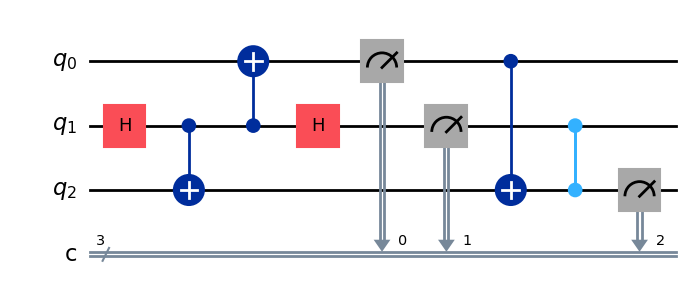

In [ ]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

circuit = QuantumCircuit(3, 3)

#instead of getting |0>, we apply a X gate resulting in |1> for q_0
#circuit.x(0) 

#creation of a Bell state
circuit.h(1)
circuit.cx(1,2)

#first and second step
circuit.cx(1,0)
circuit.h(1)

#third step
circuit.measure(0, 0)
circuit.measure(1, 1)

#fourt step: after measurement, the states are projected into their respective subspaces (no need for using the measurement outcome directly)
circuit.cx(0,2)
circuit.cz(1, 2)

#retrieve q_0 into q_2 and measure
circuit.measure(2, 2)

circuit.draw(output="mpl")

Let's apply run a simulator to confirm the theoretical expectation

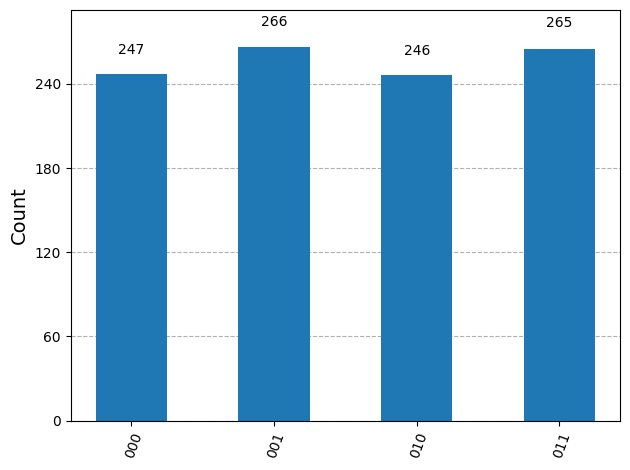

In [65]:
simulator = AerSimulator()
circ = transpile(circuit, simulator)

result = simulator.run(circ).result()
counts = result.get_counts(circ)

plot_histogram(counts)

Since $\ket{\phi}$ is initialized as $\ket{0}$. We indeed have $0$ as the only outcome of the experiment. That protocol can be more assessed by applying a $X$ gate to $\ket{\phi}$.